In [29]:
source("setup.r")


Setup complete: IRkernel and required packages installed successfully.


In [41]:
# Load necessary libraries
library(readxl)
library(ggplot2)
library(dplyr)


# Define the path to the Excel file
excel_file <- "Output Path/consolidated_output.xlsx"

# Extract the directory path dynamically
output_dir <- dirname(excel_file)

if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}

# Define custom color palette
custom_colors <- c(
  "dark_purple" = "#322564",
  "light_gray" = "#F9F8FA",
 # "white" = "#FFFFFF",
  "bright_pink" = "#D42D85",
  "pink" = "#F38CBA",
  "light_pink" = "#FFDFEF",
  "bright_purple" = "#856BFF",
  "light_purple" = "#E4E0F7",
  "sky_blue" = "#50A0FF",
  "light_sky_blue" = "#BBDAFF",
  "green" = "#55E0B5",
  "light_green" = "#C1F5E5",
  "yellow" = "#F6E580",
  "light_yellow" = "#F5FDD0",
  "red_orange" = "#FC8C73",
  "light_red_orange" = "#FFBDAF"
)

get_custom_palette <- function(type, n = NULL) {
  if (type == "categorical") {
    if (!is.null(n) && n > length(custom_colors)) {
      stop("Not enough colors for the number of categories. Add more custom colors.")
    }
    return(custom_colors[1:n])
  } else if (type == "continuous") {
    return(colorRampPalette(custom_colors)(n))
  } else {
    stop("Invalid type. Use 'categorical' or 'continuous'.")
  }
}
# Define a function to group carton types
group_carton_types <- function(carton_name) {
  if (grepl("Box", carton_name)) {
    if (grepl("Small", carton_name)) {
      return("Small Boxes")
    } else if (grepl("Medium", carton_name)) { # Corrected placement of else-if
      return("Medium Boxes")
    } else if (grepl("Large", carton_name)) {
      return("Large Boxes")
    }
  } else if (grepl("Mailer", carton_name)) {
    return("Mailers")
  } else {
    return("Other") # Catch-all for non-Box and non-Mailer types
  }
}

for (sheet in sheets) {
  df <- read_excel(excel_file, sheet = sheet)

  # Print sheet name and column names for debugging
  print(paste("Sheet:", sheet))
  print(names(df))

  # Apply grouping logic
  if ("name" %in% names(df)) {
    df <- df %>%
      mutate(grouped_name = sapply(name, group_carton_types))
  }
# 1: Actual_weight / Billed_Weight
if (all(c("total_weight", "Billed_Weight") %in% names(df))) {
  # Select two colors for the gradient
  two_color_palette <- c(custom_colors["dark_purple"], custom_colors["bright_pink"])
  
  p1 <- ggplot(df, aes(y = total_weight, x = Billed_Weight, color = total_weight)) +
    geom_point(alpha = 0.6) +
    scale_color_gradient(low = two_color_palette[2], high = two_color_palette[1]) +
    labs(title = "Actual Weight vs. Billed_Weight", x = "Actual Weight", y = "Billed Weight") 
  
  ggsave(filename = file.path(output_dir, "actual_vs_billed_weight.png"), plot = p1, width = 8, height = 6)      
}

  # 2: Dim_weight / Billed_Weight
  if (all(c("dim_weight", "Billed_Weight") %in% names(df))) {
    color_palette <- c(custom_colors["sky_blue"], custom_colors["bright_purple"])
    p2 <- ggplot(df, aes(x = Billed_Weight, y = dim_weight, color = dim_weight)) +
    geom_point(alpha = 0.7) +
    scale_color_gradient(low = color_palette[2], high = color_palette[1]) +
    labs(title = "Dimensional Weight vs. Billed Weight", x = "Dimensional Weight", y = "Billed Weight") 
    ggsave(filename = file.path(output_dir, "dim_vs_billed_weight.png"), plot = p2, width = 10, height = 6)
  }

  # 3: Volume_utilization / carton_type(name)
  if (all(c("volume_utilization", "name", "grouped_name") %in% names(df))) {
    color_palette <- c(custom_colors["red_orange"], custom_colors["light_purple"])
    p3 <- ggplot(df, aes(x = reorder(name, volume_utilization, FUN = median), y = volume_utilization, fill = grouped_name)) +
    geom_boxplot() +
    scale_color_gradient(low = color_palette[2], high = color_palette[1]) +
    facet_wrap(~ grouped_name, scales = "free_x", nrow = 1, strip.position = "top") +
    labs(title = "Volume Utilization by Carton Group", x = "Carton Group", y = "Volume Utilization") +
    scale_x_discrete(labels = function(x) ifelse(seq_along(x) %% 2 == 0, x, "")) +
    theme(axis.text.x = element_text(angle = 30, hjust = 1, size = 8), strip.text = element_text(size = 12, face = "bold"), legend.position = "none")
    ggsave(filename = file.path(output_dir, "volume_utilization_by_carton_type.png"), plot = p3, width = 8, height = 6)
  }

  # 4: Price / carton_type
  if (all(c("Price", "name", "grouped_name") %in% names(df))) {
    color_palette <- c(custom_colors["light_sky_blue"], custom_colors["light_red_orange"])
    p4 <- ggplot(df, aes(x = reorder(name, Price, FUN = median), y = Price, fill = grouped_name)) +
    geom_boxplot() +
    scale_color_gradient(low = color_palette[2], high = color_palette[1]) +
    facet_wrap(~ grouped_name, scales = "free_x", nrow = 1, strip.position = "top") +
    labs(title = "Price by Carton Group", x = "Carton Group", y = "Price") +
    scale_x_discrete(labels = function(x) ifelse(seq_along(x) %% 2 == 0, x, "")) +
    theme(axis.text.x = element_text(angle = 30, hjust = 1, size = 8), strip.text = element_text(size = 12, face = "bold"), legend.position = "none")
    ggsave(filename = file.path(output_dir, "price_by_carton_type.png"), plot = p4, width = 8, height = 6)
  }

  # 5: Counts of cartons billed at actual(dimmed) / counts of cartons billed at dim weight
  if (all(c("Dimmed", "Billed_Weight") %in% names(df))) {
   color_palette <- c(custom_colors["bright_purple"], custom_colors["pink"])
    p5 <- ggplot(df, aes( x = Dimmed, y = Billed_Weight, fill = Dimmed)) +
    geom_bar(stat = "identity", alpha = 0.6) +
    scale_color_gradient(low = color_palette[2], high = color_palette[1]) +
    labs(title = "Counts of Cartons Billed at Dimmed vs. Billed_Weight", x = "Dimmed Count", y = "Billed Weight Count") 
    ggsave(filename = file.path(output_dir, "cartons_billed_actual_vs_dim.png"), plot = p5, width = 8, height = 6)
  }

  # 6: Cost / carton_type(name)
  if (all(c("base_cost", "name", "grouped_name") %in% names(df))) {
    color_palette <- c(custom_colors["dark_purple"], custom_colors["light_pink"])
    p6 <- ggplot(df, aes(x = reorder(name, base_cost, FUN = median), y = base_cost, fill = grouped_name)) +
    geom_boxplot() +
    scale_color_gradient(low = color_palette[2], high = color_palette[1]) +
    facet_wrap(~ grouped_name, scales = "free_x", nrow = 1, strip.position = "top") +
    labs(title = "Cost by Carton Group", x = "Carton Group", y = "Cost") +
    scale_x_discrete(labels = function(x) ifelse(seq_along(x) %% 2 == 0, x, "")) +
    theme(axis.text.x = element_text(angle = 30, hjust = 1, size = 8), strip.text = element_text(size = 12, face = "bold"), legend.position = "none")
    ggsave(filename = file.path(output_dir, "cost_by_carton_type.png"), plot = p6, width = 8, height = 6)
  }
  # 8: Orders billed over actual weight (Histogram)
  if (all(c("total_weight", "Billed_Weight") %in% names(df))) {
    df_hist <- df %>%
    mutate(bin = cut(total_weight, breaks = seq(min(total_weight, na.rm = TRUE), max(total_weight, na.rm = TRUE), length.out = 31))) %>%
    group_by(bin) %>%
    summarize(count = n(), .groups = "drop")
    color_palette <- c(custom_colors["dark_purple"], custom_colors["light_pink"])
    p8 <- ggplot(df_hist, aes(x = bin, y = count, fill = count)) +
    geom_col(alpha = 0.8) +
    scale_fill_gradient(low = custom_colors[1], high = custom_colors[2]) +
    labs(title = "Orders Billed Over Actual Weight", x = "Total Weight Bins (lbs)",  y = "Count") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "none")
    ggsave(filename = file.path(output_dir, "orders_billed_over_actual_weight.png"), plot = p8, width = 8, height = 6)
  }
}

print("All individual plots have been generated and saved as PNG files where data was complete.")

[1] "Sheet: Consolidated Output"
 [1] "orderId"            "refId"              "index"             
 [4] "name"               "dimensions"         "Price"             
 [7] "base_cost"          "Carton_volume"      "Order_volume"      
[10] "volume_utilization" "surface_area"       "total_weight"      
[13] "net_weight"         "tare_weight"        "weight_utilization"
[16] "dim_weight"         "item_count"         "source_flag"       
[19] "Dimmed"             "Billed_Weight"      "L"                 
[22] "W"                  "H"                  "SA"                


ERROR: [1m[33mError[39m in `scale_color_manual()`:[22m
[1m[22m[33m![39m Continuous values supplied to discrete scale.
[36mℹ[39m Example values: [34mMailers[39m, [34mMailers[39m, [34mMailers[39m, [34mMailers[39m, and [34mMailers[39m


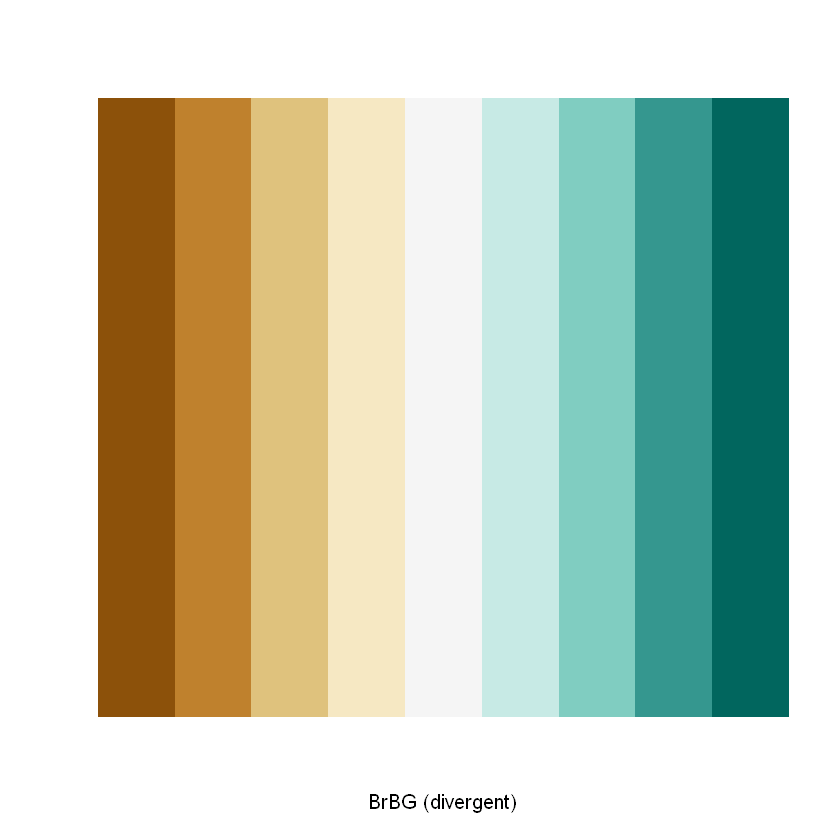

In [9]:
library(RColorBrewer)
display.brewer.pal(9,"BrBG")

In [ ]:
# Load necessary libraries
library(readxl)
library(ggplot2)
library(dplyr)
library(progress)

# Define the path to the Excel file
excel_file <- "Output Path/consolidated_output.xlsx"

# Extract the directory path dynamically
output_dir <- dirname(excel_file)

if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}

# Define custom color palette
custom_colors <- c(
  "dark_purple" = "#322564",
  "light_gray" = "#F9F8FA",
  "bright_pink" = "#D42D85",
  "pink" = "#F38CBA",
  "light_pink" = "#FFDFEF",
  "bright_purple" = "#856BFF",
  "light_purple" = "#E4E0F7",
  "sky_blue" = "#50A0FF",
  "light_sky_blue" = "#BBDAFF",
  "green" = "#55E0B5",
  "light_green" = "#C1F5E5",
  "yellow" = "#F6E580",
  "light_yellow" = "#F5FDD0",
  "red_orange" = "#FC8C73",
  "light_red_orange" = "#FFBDAF"
)

get_custom_palette <- function(type, n = NULL) {
  if (type == "categorical") {
    if (!is.null(n) && n > length(custom_colors)) {
      stop("Not enough colors for the number of categories. Add more custom colors.")
    }
    return(custom_colors[1:n])
  } else if (type == "continuous") {
    return(colorRampPalette(custom_colors)(n))
  } else {
    stop("Invalid type. Use 'categorical' or 'continuous'.")
  }
}

# Define a function to group carton types
group_carton_types <- function(carton_name) {
  if (grepl("Box", carton_name)) {
    if (grepl("Small", carton_name)) {
      return("Small Boxes")
    } else if (grepl("Medium", carton_name)) {
      return("Medium Boxes")
    } else if (grepl("Large", carton_name)) {
      return("Large Boxes")
    }
  } else if (grepl("Mailer", carton_name)) {
    return("Mailers")
  } else {
    return("Other")
  }
}

# Perform PCA on relevant numeric columns
perform_pca <- function(data, numeric_columns, group_column) {
  pca_data <- data %>%
    select(all_of(numeric_columns)) %>%
    drop_na()
  
  # Apply PCA
  pca_result <- prcomp(pca_data, center = TRUE, scale. = TRUE)
  pca_scores <- as.data.frame(pca_result$x[, 1:2])  # Extract PC1 and PC2
  colnames(pca_scores) <- c("PC1", "PC2")
  pca_scores[[group_column]] <- data[[group_column]][!is.na(rowSums(pca_data))]
  
  return(list(pca_scores = pca_scores, pca_result = pca_result))
}

# Initialize progress bar with dplyr's progress_estimated
pb <- progress_estimated(length(sheets))

sheets <- excel_sheets(excel_file)  # Ensure sheets are initialized
for (sheet in sheets) {
  pb$tick()$print()  # Update progress bar
  
  df <- read_excel(excel_file, sheet = sheet)
  
  # Print sheet name and column names for debugging
  print(paste("Sheet:", sheet))
  print(names(df))
  
  # Apply grouping logic
  if ("name" %in% names(df)) {
    df <- df %>%
      mutate(grouped_name = sapply(name, group_carton_types))
  }
  
  # PCA for Volume Utilization, Price, and Cost
  if (all(c("volume_utilization", "Price", "base_cost", "name") %in% names(df))) {
    numeric_columns <- c("volume_utilization", "Price", "base_cost")
    group_column <- "grouped_name"
    
    # Perform PCA
    pca_output <- perform_pca(df, numeric_columns, group_column)
    pca_scores <- pca_output$pca_scores
    
    # Plot PCA results
    pca_plot <- ggplot(pca_scores, aes(x = PC1, y = PC2, color = grouped_name)) +
      geom_point(alpha = 0.7, size = 3) +
      scale_color_manual(values = get_custom_palette("categorical", length(unique(pca_scores[[group_column]])))) +
      labs(title = "PCA of Carton Types", x = "Principal Component 1", y = "Principal Component 2", color = "Carton Group") +
      theme_minimal()
    
    # Save PCA plot
    ggsave(filename = file.path(output_dir, paste0("pca_carton_types_", sheet, ".png")), plot = pca_plot, width = 8, height = 6)
  }

  # Section 3: Volume Utilization
  if (all(c("volume_utilization", "name", "grouped_name") %in% names(df))) {
    p3 <- ggplot(df, aes(x = reorder(name, volume_utilization, FUN = median), y = volume_utilization, fill = grouped_name)) +
      geom_boxplot() +
      facet_wrap(~ grouped_name, scales = "free_x", nrow = 1, strip.position = "top") +
      scale_x_discrete(labels = function(x) ifelse(seq_along(x) %% 2 == 0, x, "")) +
      theme(axis.text.x = element_text(angle = 30, hjust = 1, size = 8)) +
      labs(title = "Volume Utilization by Carton Group", x = "Carton Group", y = "Volume Utilization")
    ggsave(filename = file.path(output_dir, "volume_utilization_by_carton_type.png"), plot = p3, width = 8, height = 6)
  }
  
  # Section 4: Price
  if (all(c("Price", "name", "grouped_name") %in% names(df))) {
    p4 <- ggplot(df, aes(x = reorder(name, Price, FUN = median), y = Price, fill = grouped_name)) +
      geom_boxplot() +
      facet_wrap(~ grouped_name, scales = "free_x", nrow = 1, strip.position = "top") +
      scale_x_discrete(labels = function(x) ifelse(seq_along(x) %% 2 == 0, x, "")) +
      theme(axis.text.x = element_text(angle = 30, hjust = 1, size = 8)) +
      labs(title = "Price by Carton Group", x = "Carton Group", y = "Price")
    ggsave(filename = file.path(output_dir, "price_by_carton_type.png"), plot = p4, width = 8, height = 6)
  }
  
  # Section 6: Cost
  if (all(c("base_cost", "name", "grouped_name") %in% names(df))) {
    p6 <- ggplot(df, aes(x = reorder(name, base_cost, FUN = median), y = base_cost, fill = grouped_name)) +
      geom_boxplot() +
      facet_wrap(~ grouped_name, scales = "free_x", nrow = 1, strip.position = "top") +
      scale_x_discrete(labels = function(x) ifelse(seq_along(x) %% 2 == 0, x, "")) +
      theme(axis.text.x = element_text(angle = 30, hjust = 1, size = 8)) +
      labs(title = "Cost by Carton Group", x = "Carton Group", y = "Cost")
    ggsave(filename = file.path(output_dir, "cost_by_carton_type.png"), plot = p6, width = 8, height = 6)
  }
}

print("PCA and individual plots have been generated and saved as PNG files.")
